In [39]:
import warnings
from datetime import date
from itertools import combinations_with_replacement

import matplotlib.pyplot as plt
import seaborn as sns
import pandas
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.simplefilter("ignore", FutureWarning)  # ignore some seaborn warnings until they update numpy

In [2]:
df = pandas.read_csv("NHL_API_point_totals_by_team_season_raw_1996-2003.csv")
vegas_df = df[df["team"] == "VGK"].copy()
vegas_df

,team,season_end,total_points,points_rank
673,VGK,2018,109,5
704,VGK,2019,93,15
735,VGK,2020,86,7
766,VGK,2021,82,2
797,VGK,2022,94,17
829,VGK,2023,111,5


In [3]:
vegas_df["season_end"] = vegas_df["season_end"].apply(lambda x : date(month=5, day=1, year=x))
vegas_df["season_end"] = pandas.to_datetime(vegas_df["season_end"])

In [4]:
vegas_df = vegas_df.set_index("season_end")

In [35]:
ar = AutoReg(vegas_df["total_points"][0:-1], lags=1, trend="ct").fit()

/Users/diane/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-MAY will be used.
  self._init_dates(dates, freq)


In [36]:
ar.forecast(1)

/Users/diane/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2023-05-01    121.511905
Freq: AS-MAY, dtype: float64

In [37]:
ar = AutoReg(vegas_df["total_points"], lags=1, trend="ct").fit()

/Users/diane/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-MAY will be used.
  self._init_dates(dates, freq)


In [38]:
ar.forecast(1)

/Users/diane/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2024-05-01    137.595593
Freq: AS-MAY, dtype: float64

In [48]:
bootstrap_forecasts = []
for combo in combinations_with_replacement(vegas_df["total_points"][0:-1], len(vegas_df[0:-1])):
    s = pandas.Series(combo, index=vegas_df[0:-1].index)
    ar = AutoReg(s, lags=1, trend="ct").fit()
    bootstrap_forecasts.append(ar.forecast(1).values[0])

/Users/diane/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-MAY will be used.
  self._init_dates(dates, freq)
/Users/diane/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Users/diane/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-MAY will be used.
  self._init_dates(dates, freq)
/Users/diane/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a u

In [49]:
np.mean(bootstrap_forecasts)

86.10221037703883

In [50]:
np.std(bootstrap_forecasts, ddof=1)

14.464437135261056

In [51]:
np.min(bootstrap_forecasts)

49.6522639286316

In [52]:
np.max(bootstrap_forecasts)

132.40650406503647

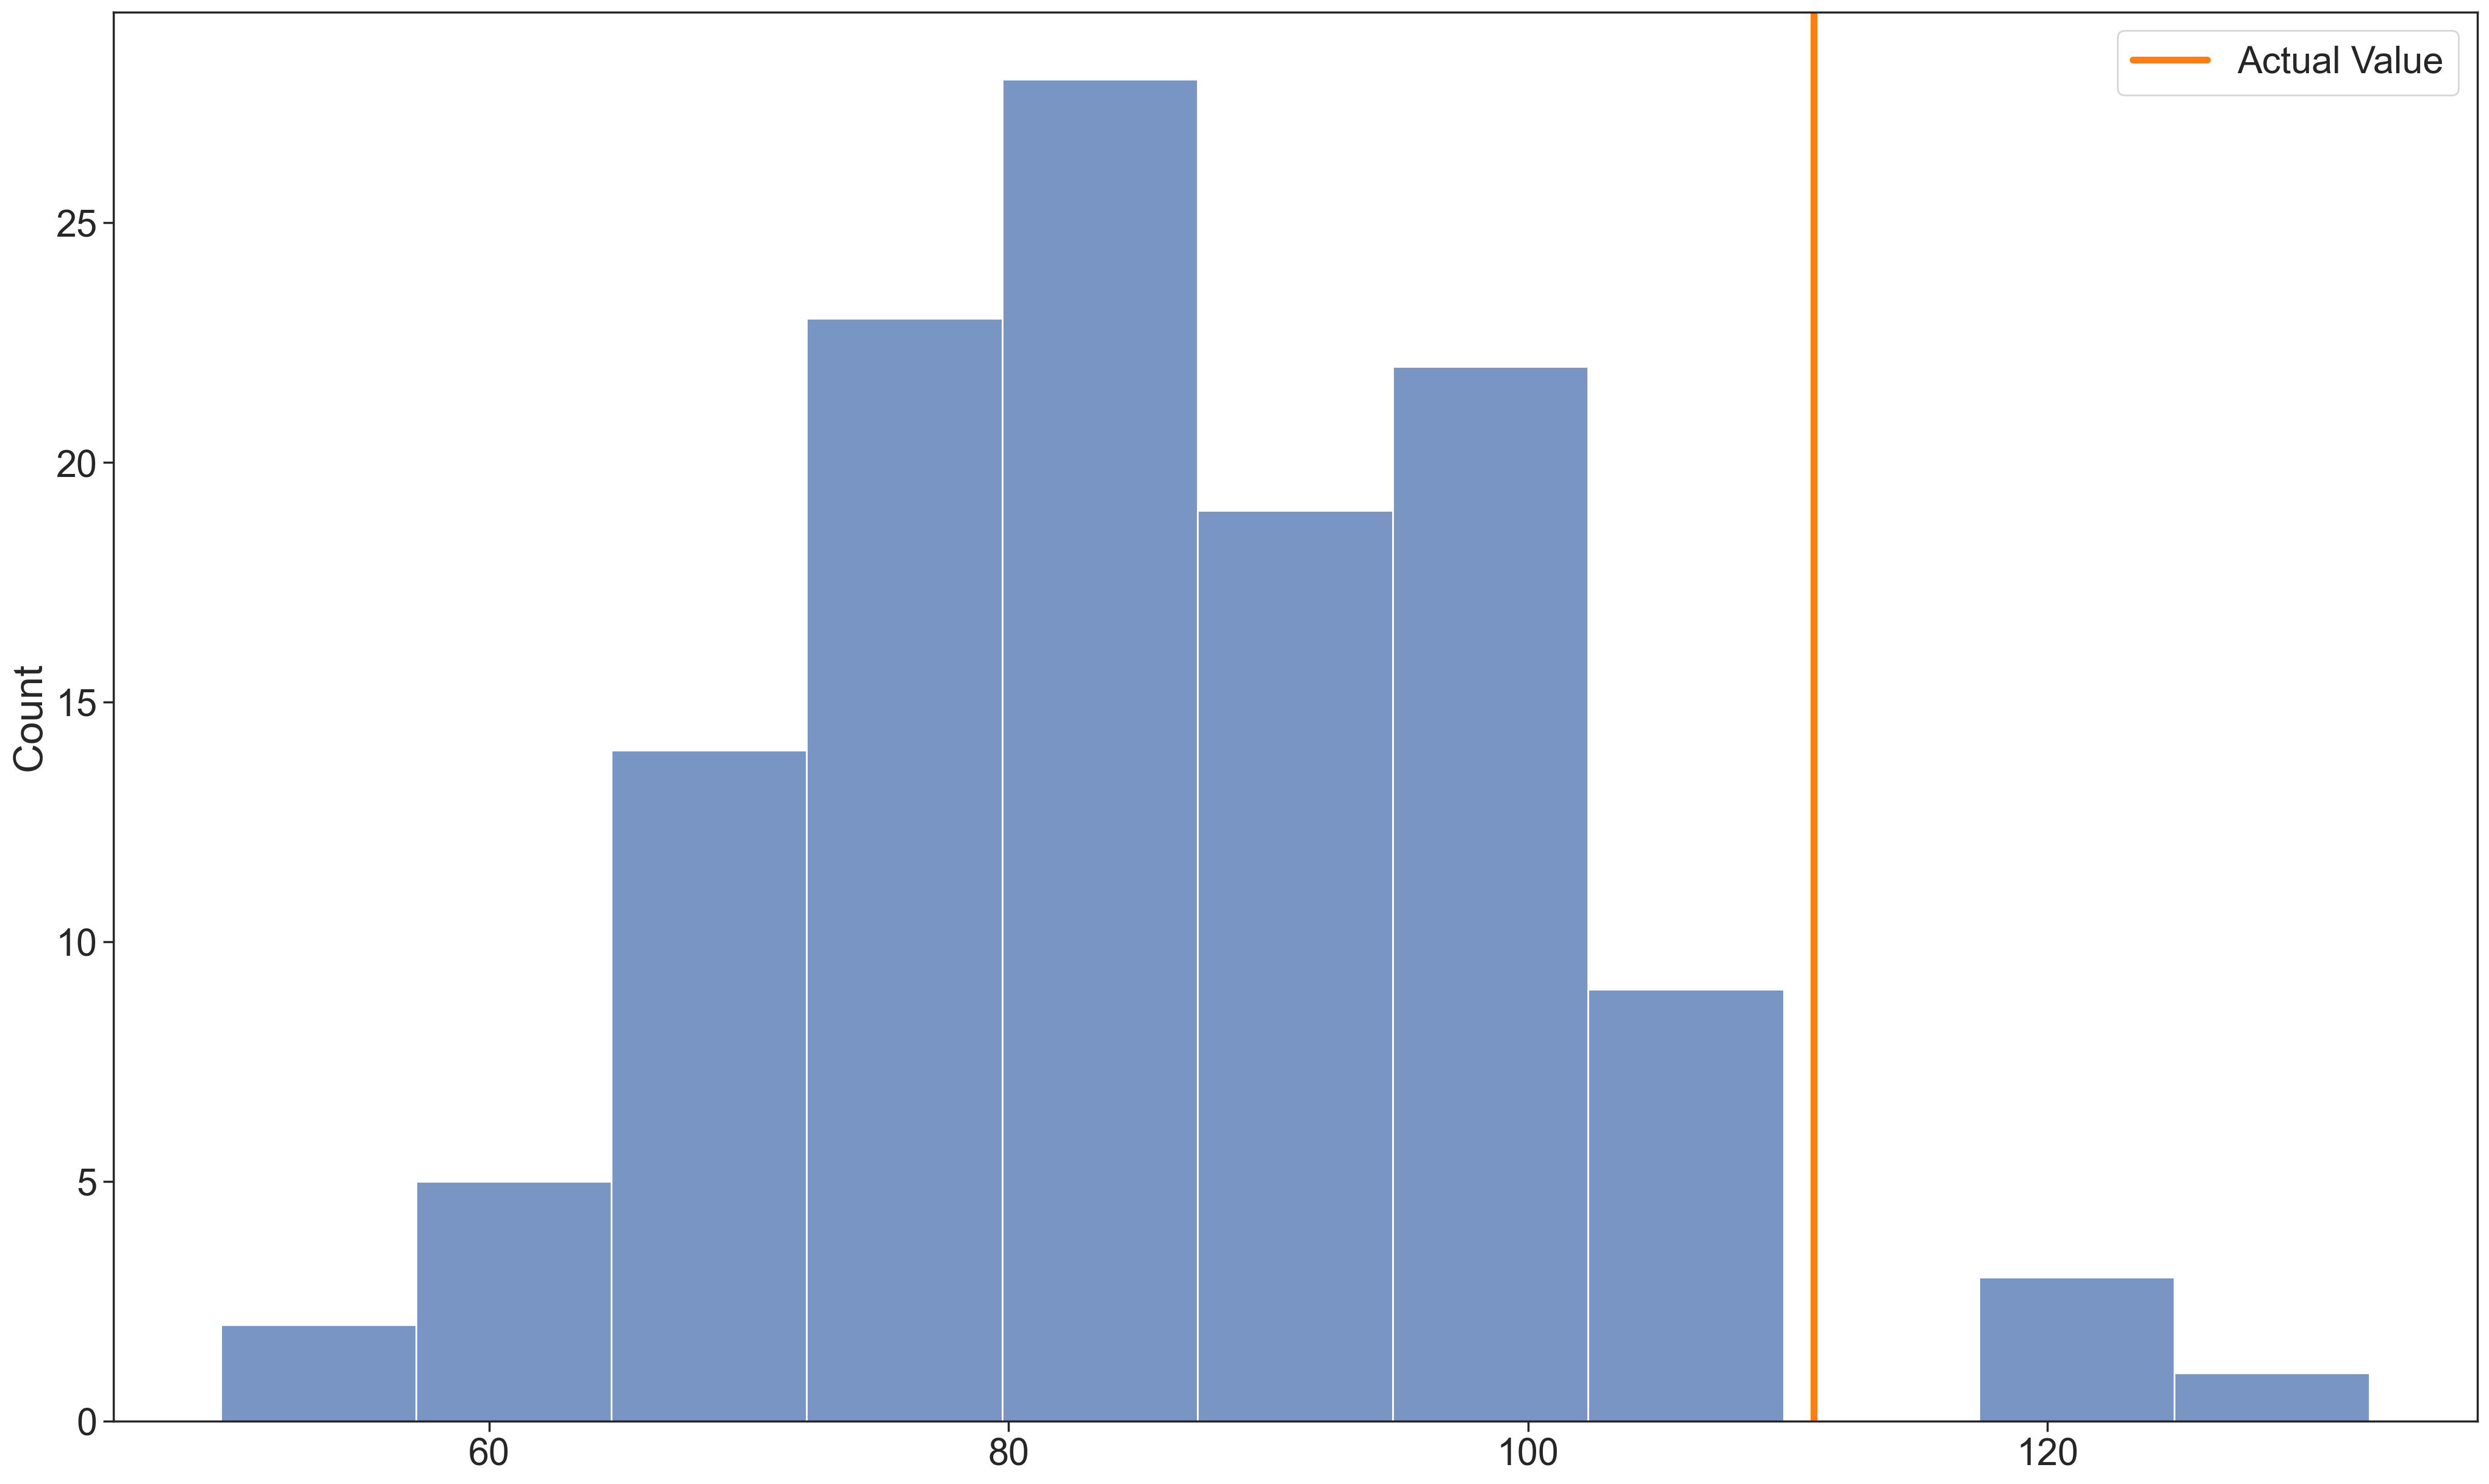

In [56]:
ax = sns.histplot(x=bootstrap_forecasts)
ax.axvline(vegas_df["total_points"][-1], linewidth=4, color="tab:orange", label="Actual Value")
ax.legend()
plt.show()